## Table of Contents

1. Setup/Convenience Functions: [Universe Filters](#Universe) | [Functions](#Convenience Functions) | [Custom Factors](#Custom Factors)<br>

2. Loading Data: [Pipeline](#Pipeline) | [processing pipeline](#acctg_pipes_loaded) | 

3. Clearning Functions: [Non Financial Statement info](#nfo wrangling) | [Fundamental Data](#FS wrangling) 

4. Reshaping Functions: [FS Reformulation](#FS Reformulation) 

5. Miscellaneous:[Regression](#Regression) | [Factor Analysis](#Factor Analysis) | [acctg_lists](#acctg_lists) | [acctg_pipes](#acctg_pipes) | [Code Snipets](#Code Snipets)

Press $<$Ctrl + Home Key$>$ to return to table of contents <br>
[Bookmark](#buffer)


## ------------------BOOKMARK------------------ <a id='buffer'></a> 

## Libraries

In [1]:
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import CustomFactor, Returns
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage, AverageDollarVolume
from quantopian.pipeline import CustomFactor
from quantopian.pipeline.data.morningstar import operation_ratios, valuation_ratios
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q1500US, Q500US
from quantopian.pipeline.data.sentdex import sentiment  # sentiment score for each company
from quantopian.pipeline.factors.morningstar import MarketCap
from quantopian.pipeline.data import builtin, morningstar as mstar
from quantopian.pipeline.filters import StaticAssets
# fundamentals = init_fundamentals()  # initialize fundamentals to use get_fundamentals

# The sample and full version is found through the same namespace  
# https://www.quantopian.com/data/eventvestor/earnings_calendar  
# Sample date ranges: 01 Jan 2007 - 10 Feb 2014  
from quantopian.pipeline.data.eventvestor import EarningsCalendar  
from quantopian.pipeline.factors.eventvestor import (  
    BusinessDaysUntilNextEarnings,  
    BusinessDaysSincePreviousEarnings  
)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels import regression
import scipy.stats
import scipy as sp
import re
from datetime import datetime, timedelta
import blaze as bz
from blaze import by, join, merge, concat
import alphalens as al
import pprint as pp
import time
import calendar
import collections
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import Day, MonthEnd, MonthBegin


# from quantopian.pipeline.data.estimize import (  
#     ConsensusEstimizeEPS,  
#     ConsensusWallstreetEPS,  
#     ConsensusEstimizeRevenue,  
#     ConsensusWallstreetRevenue  
# )


## Convenience Functions <a id='Convenience Functions'></a>

In [1]:
def timeit(method):
    """decorator to evaluate the runtime of any function""" 
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        hrs, rem = divmod(te-ts,3600)
        mins, secs = divmod(te-ts,60)
        print 'Run time: {} {} hrs {} mins {:4.4f} secs'.format(method.__name__, int(hrs), int(mins), secs)
        # print 'Run time: %r %2.2f sec' %(method.__name__, te-ts)
        return result
    return timed


@timeit
def run_pipeline_list(pipe, pipeline_dates):  
    """
    @summary: Drop-in replacement for run_pipeline; problem/solution:   
        run_pipeline fails over a very long period of time (memory usage),  
        so we need to split in chunks the pipeline and concatenate the results  
    @param pipeline_dates: list of dates to grab data for (eg. list of month end dates)
    @param pipe: pipeline name (init feature columns)
    @return dataframe corrresponding to pipeline columns initialized
    """
    chunks  = [] 
    item_count = 0
    start = time.time() 
    for date in pipeline_dates:
        
        # debugging/timing -> remove in production
        print "Processing {:.10} pipeline".format(str(date[0]))
        
        # beg_date = end_date since each data point is in a new week:i.e. dicontinuous time intervals
        results = run_pipeline(pipe, date[0], date[0])  
        for col in list(results.select_dtypes(include=['category']).columns):
            results[col] = results[col].astype('O')  # convert category dtype to Object for pd.concat fix
        chunks.append(results)
        
        # debugging/timing -> remove in production
        end = time.time()    
        item_count += 1
        elapsed = (end - start)
        est_wait = (len(pipeline_dates) - item_count) * (elapsed/item_count)
        elapsed_min, elapsed_sec = divmod(elapsed, 60)
        est_min, est_sec = divmod(est_wait, 60)
        print 'elapsed time: {} mins {} secs'.format(int(elapsed_min), int(elapsed_sec))
        print'shape: {1}'.format(str(date[0]),results.shape)
        print 'estimated wait: {} mins {} secs\n'.format(int(est_min), int(est_sec))
    
    results = pd.concat(chunks)
    # convert Object dtype columns back to category after pd.concat
    for col in list(results.select_dtypes(include=['O']).columns):
            results[col] = results[col].astype('category')  
            
    print '\nCombined dataframe created'
    return results

@timeit
def dt_intervals(beg_date, end_date, day_index):
    """ 
    @summary Creates datetime intervals to save on memory 
    @param day_index => day of the week to run calculations
    @param 0-mon, 1-tues, ... 4-fri
    @return list of timestamps
    """ 
    trng = pd.date_range(beg_date, end_date)
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=trng.min(), end=trng.max()) 
    # list of holidays occuring btn start/end dates
    trng_no_holidays = trng[~trng.isin(holidays)]  
    # make sure eligible valid date df excludes US holidays
    trng_no_holidays_wknds = trng_no_holidays[trng_no_holidays.weekday < 5]  
    # exclude saturday/sunday; != 5/6
    pipeline_dates = []

    for year in set(trng_no_holidays_wknds.year):    
    # set -> get unique year values in time range
        tmp = trng_no_holidays_wknds[trng_no_holidays_wknds.year == year] 
        # slice year wise
        for week in set(tmp.week):  # for each week in slice
            temp = tmp[tmp.week == week]
            day = temp[temp.weekday == day_index]  
            # select a day of the week 0-monday, 1-tues...
            if len(day) == 1: pipeline_dates.append(day) 
            else: pipeline_dates.append(temp[temp.weekday == temp.weekday.max()]) 
            # last day of week if problem
            # pipeline_dates.append(temp[temp.weekday == temp.weekday.min()]) 
            # begining of week
    return sorted(pipeline_dates)

@timeit
def run_pipeline_chunks(pipe, start_date, end_date, chunks_len = None):  
    """ 
    @summary: Drop-in replacement for run_pipeline. Run_pipeline fails over 
        a very long period of time (memory usage), so we need to split in 
        chunks the pipeline and concatenate the results  
    @param start_date/end_date: start and end timestamps
    @param chunks_len: number of pipeline weeks to process each data call
    @param pipe: pipeline name (init feature columns)
    @return dataframe corrresponding to pipeline columns initialized
    """
    chunks  = []  
    current = pd.Timestamp(start_date)  
    end     = pd.Timestamp(end_date)  
    step    = pd.Timedelta(weeks=26) if chunks_len is None else chunks_len  
    while current <= end:  
        current_end = current + step  
        if current_end > end:  
            current_end = end  
        print 'Running pipeline: {:.10} - {:.10}'.format(str(current), str(current_end))
        results = run_pipeline(pipe, current.strftime("%Y-%m-%d"), current_end.strftime("%Y-%m-%d"))  
        for col in list(results.select_dtypes(include=['category']).columns):
            results[col] = results[col].astype('O')  # convert category dtype to Object
            # pd.concat fails if category levels are different between dataframes
            # convert to dtype Object to get around this problem
        chunks.append(results)  
        # pipeline returns more days than requested (if no trading day), so get last date from the results  
        current_end = results.index.get_level_values(0)[-1].tz_localize(None)  
        current = current_end + pd.Timedelta(days=1)
    try:
        results = pd.concat(chunks)
        for col in list(results.select_dtypes(include=['O']).columns):
            results[col] = results[col].astype('category')
        print 'Combined dataframe created'
        return results
    
    except:
        print 'pd.concat failed'
        return chunks

def Trl_dates (end_date, per, mltplr):
    """gets dates for trailing information update intervals""" 
    end_date = datetime.strptime(end_date[0], '%Y-%m-%d')
    out = []
    for n in xrange(per):
        if n != 0:
            Q = str(end_date - MonthEnd(mltplr)*n)[:10]
            out.append([Q])
        else: pass
    end_date = str(end_date)[:10]
    out.append([end_date])
    return sorted(out)

# @timeit
def sum_col_append(df_tgt, df_src, var_list):
    """sums DF columns and adds them to a tgt DF"""
    for var, components in var_list.iteritems():
        df_tgt[var] = df_src[components].sum(axis = 1)
    return df_tgt

@timeit
def mltplyArr(FS, asof_valid):
    """iterative multiplication of two lists of dataframes"""
    out = []
    for arr in zip(FS, asof_valid):
        out.append(pd.DataFrame(arr[0].values * arr[1].values, 
                                columns=arr[0].columns, 
                                index=arr[0].index))
    return out

@timeit
def subset_df(src_df, srchType, srchStrngs, mrg_out = True ):
    """
    @summary: creates subset dataframes based on column index label in source DF
    @param src_df (source dataframe) : list of dataframes to slice
    @param srchType (column title search type): valid inputs = 'startswith', 'contains', '!contains' 
    @param srchStrngs (search string) : list of strings to find must be entered as a regular express
    @param mrg_out (merge output): switch to determine if srchStrngs matches 
        should be outputted as a single merged dataframe (if false, separate df created for each match)
    @return: subset dataframe based on search string parameters
    """
    out = []
    if srchType == 'startswith':
        if mrg_out == True:
            return src_df[src_df.columns[pd.Series(src_df.columns).str.startswith(tuple(srchStrngs))]]
        else:
            for strng in srchStrngs:
                out.append(src_df[src_df.columns[pd.Series(src_df.columns).str.startswith(strng)]])
            return out
    elif srchType == 'contains':
        if mrg_out == True: 
            srchStrngs = '|'.join(srchStrngs)
            return src_df.filter(regex=srchStrngs, axis = 1)
        else:
            for idx, string in enumerate(srchStrngs):
                out.append(src_df[idx][src_df[idx].columns[pd.Series(src_df[idx].columns).str.contains(string)]])
            return out
    elif srchType == '!contains':
        if mrg_out == True:
            srchStrngs = '|'.join(srchStrngs)
            srchStrngs = '^((?!' + srchStrngs + ').)*$'  # regex for match exclusion
            return src_df.filter(regex=srchStrngs, axis =1)
        else:
            for idx, string in enumerate(srchStrngs):
                out.append(src_df[idx][src_df[idx].columns[pd.Series(src_df[idx].columns).str.contains(string)==False]])
            return out 
    else: print 'invalid subset_df parameter input'


@timeit        
def drop_rows(df_list, bad_rows): 
    """Drops bad_rows(index) from each dataframe in df_list"""
    out = []
    for df in df_list:
        out.append(df[~df.index.isin(bad_rows)])
    return out

@timeit
def date_validate(asof_df, asof_maxdates):  
    """ 
    @summary: Create boolean df to determine which financial statement numbers 
        are still relevant. These boolean validation tables will be multiplied (element by element)
        by relevant financials statement df
    @param asof_df = pd.dataframe of datetimes(ns); 
    @param asof_maxdates = pd.series of datetimes(ns)
    @return asof_lag: (days) difference between most recent asof date on record (asof_maxdates) 
        for a particular point in time and the asof date associated with a particular 
        financial statement line item.     
    @return asof_maxdates: boolean df where value = 1 indicates an item's as_of date matches
        the most recent asof date on record.
    """
    asof_lag = -asof_df.sub(asof_maxdates, axis = 0)
    asof_valid = asof_lag.astype(int)
    asof_valid[asof_valid != 0] = np.NaN 
    asof_valid[asof_valid == 0] = 1
    return asof_lag, asof_valid  


## Custom Factors <a id='Custom Factors'></a>

In [3]:
# DollarVolume will calculate yesterday's dollar volume for each stock in the universe.
class DollarVolume(CustomFactor):
    
    # We need close price and trade volume for this calculation.
    inputs = [USEquityPricing.close, 
              USEquityPricing.volume]
    window_length = 1
    
    # Dollar volume is volume * closing price.
    def compute(self, today, assets, out, close, volume):
        out[:] = (close[0] * volume[0])
        

## Universe Filters<a id='Universe'></a>

In [4]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Setup stock universe filters and assign global variables 
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# global variables---------------------------------------
sector_code = morningstar.asset_classification.morningstar_sector_code.latest
AC  = morningstar.asset_classification
BS  = morningstar.balance_sheet
IS  = morningstar.income_statement
CFS = morningstar.cash_flow_statement
CR  = morningstar.company_reference
ER  = morningstar.earnings_report
GP  = morningstar.general_profile
V   = morningstar.valuation
FSF = morningstar.financial_statement_filing
Price = builtin.USEquityPricing

morningstar_sector_codes = {  
     -1: 'Misc',  
    101: 'Basic Materials',  
    102: 'Consumer Cyclical',  
    103: 'Financial Services',  
    104: 'Real Estate',  
    205: 'Consumer Defensive',  
    206: 'Healthcare',  
    207: 'Utilities',  
    308: 'Communication Services',  
    309: 'Energy',  
    310: 'Industrials',  
    311: 'Technology' ,  
}

# remove Limited Partnerships
common_stock = mstar.share_class_reference.security_type.latest.eq('ST00000001')
not_lp_name = ~mstar.company_reference.standard_name.latest.matches('.* L[\\. ]?P\.?$')
not_lp_balance_sheet = mstar.balance_sheet.limited_partnership.latest.isnull()
have_data = mstar.valuation.market_cap.latest.notnull()
ot_otc = ~mstar.share_class_reference.exchange_id.latest.startswith('OTC')
ot_wi = ~mstar.share_class_reference.symbol.latest.endswith('.WI')
ot_depository = ~mstar.share_class_reference.is_depositary_receipt.latest
# primary_share = IsPrimaryShare()


# market_cap = morningstar.valuation.market_cap.latest.top(200)
market_cap = morningstar.valuation.market_cap.latest > 1e9 #bn million
# market_cap = morningstar.valuation.market_cap.latest > 5e8 #500 million

# remove financials, utilities, real estate sectors, and energy sectors
# that are more interest rate sensitive until I can incorporate stochastic volatility
# model calibrated w\ interest rate futures data
sectors_mask = ~sector_code.element_of([103, 207, 104, 309]) 
    
# Create a dollar_volume factor using default inputs and window_length
dollar_volume = DollarVolume()

# Define high dollar-volume filter
min_dollar_volume = dollar_volume.percentile_between(30, 100)

inputs_nonull = ((  
    BS.total_assets.latest.notnull() & 
    BS.total_assets_as_of.latest.notnull()
    ) & (
    IS.operating_income.latest.notnull() &
    IS.operating_income_as_of.latest.notnull()
    ) & (
    CFS.changes_in_cash.latest.notnull() &
    CFS.changes_in_cash_as_of.latest.notnull()
)) 

base_universe = (
    Q500US()
    & market_cap
    & min_dollar_volume
    & sector_code.notnull()
    & Price.close.latest.notnull()
    & (Price.volume.latest > 0)
    & sectors_mask
    & inputs_nonull
    & common_stock 
    & not_lp_name 
    & not_lp_balance_sheet 
    # & have_data & not_otc 
    # & not_wi 
    # & not_depository 
    # & primary_share
)

## Pipeline <a id='Pipeline'></a>

In [5]:
# Create a pipline
pipe = Pipeline()

# pipe.set_screen(test_symbols)
pipe.set_screen(base_universe)

In [6]:
# nfo_pipe = Pipeline()

# pipe.set_screen(test_symbols)
# nfo_pipe.set_screen(base_universe)

# misc company info
pipe.add(sector_code, 'AC_sector')
pipe.add(CR.standard_name.latest, 'CR_name')
pipe.add(CR.fiscal_year_end.latest, 'CR_fiscal_year_end')
pipe.add(GP.short_description.latest, 'GP_short_description')
pipe.add(V.market_cap.latest, 'V_mktCp')
pipe.add(AC.financial_health_grade.latest, 'AC_finGrd')
pipe.add(AC.growth_score.latest, 'AC_gwrthScr')
pipe.add(AC.profitability_grade.latest, 'AC_prftGrd')
pipe.add(dollar_volume, 'Q_dollar_volume')
pipe.add(FSF.file_date.latest, 'FSF_file_date')
pipe.add(FSF.file_date_as_of.latest, 'FSF_file_date_asof')
pipe.add(FSF.form_type.latest, 'FSF_form_type')
pipe.add(FSF.form_type_as_of.latest, 'FSF_form_type_asof')

# get 2 month returns
returns = Returns(inputs=[USEquityPricing.close], window_length=60)
pipe.add(returns, "Q_returns")
    
# pipe.add(ER.file_date_earnings_reports.latest, 'ER_file_date_earnings_reports')
# pipe.add(ER.file_date_earnings_reports_as_of.latest, 'ER_file_date_earnings_reports_as_of')
# pipe.add(ER.form_type_earnings_reports.latest, 'ER_form_type_earnings_reports')
# pipe.add(ER.form_type_earnings_reports_as_of.latest, 'ER_form_type_earnings_reports_as_of')

pipe.add(BS.minority_interest.latest, 'BS_minority_interest')
pipe.add(BS.total_assets.latest, 'BS_total_assets')
pipe.add(BS.cash_cash_equivalents_and_marketable_securities.latest, 'BS_cash_cash_equivalents_and_marketable_securities')
pipe.add(BS.investments_and_advances.latest, 'BS_investments_and_advances')
pipe.add(BS.current_debt_and_capital_lease_obligation.latest, 'BS_current_debt_and_capital_lease_obligation')
pipe.add(BS.long_term_debt_and_capital_lease_obligation.latest, 'BS_long_term_debt_and_capital_lease_obligation')
pipe.add(BS.preferred_stock.latest, 'BS_preferred_stock')
pipe.add(BS.common_stock_equity.latest, 'BS_common_stock_equity')
pipe.add(IS.net_non_operating_interest_income_expense.latest, 'IS_net_non_operating_interest_income_expense')
pipe.add(IS.tax_rate_for_calcs.latest, 'IS_tax_rate_for_calcs')
pipe.add(IS.preferred_stock_dividends.latest, 'IS_preferred_stock_dividends')
pipe.add(IS.net_foreign_exchange_gain_loss.latest, 'IS_net_foreign_exchange_gain_loss')
pipe.add(IS.foreign_exchange_trading_gains.latest, 'IS_foreign_exchange_trading_gains')
pipe.add(IS.operating_income.latest, 'IS_operating_income')
pipe.add(IS.operating_revenue.latest, 'IS_operating_revenue')
pipe.add(IS.net_income_including_noncontrolling_interests.latest, 'IS_net_income_including_noncontrolling_interests')
pipe.add(CFS.changes_in_cash.latest, 'CFS_changes_in_cash')
pipe.add(CFS.beginning_cash_position.latest, 'CFS_beginning_cash_position')
pipe.add(CFS.operating_cash_flow.latest, 'CFS_operating_cash_flow')

pipe.add(BS.minority_interest_as_of.latest, 'BS_minority_interest_as_of')
pipe.add(BS.total_assets_as_of.latest, 'BS_total_assets_as_of')
pipe.add(BS.cash_cash_equivalents_and_marketable_securities_as_of.latest, 'BS_cash_cash_equivalents_and_marketable_securities_as_of')
pipe.add(BS.investments_and_advances_as_of.latest, 'BS_investments_and_advances_as_of')
pipe.add(BS.current_debt_and_capital_lease_obligation_as_of.latest, 'BS_current_debt_and_capital_lease_obligation_as_of')
pipe.add(BS.long_term_debt_and_capital_lease_obligation_as_of.latest, 'BS_long_term_debt_and_capital_lease_obligation_as_of')
pipe.add(BS.preferred_stock_as_of.latest, 'BS_preferred_stock_as_of')
pipe.add(BS.common_stock_equity_as_of.latest, 'BS_common_stock_equity_as_of')
pipe.add(IS.net_non_operating_interest_income_expense_as_of.latest, 'IS_net_non_operating_interest_income_expense_as_of')
pipe.add(IS.tax_rate_for_calcs_as_of.latest, 'IS_tax_rate_for_calcs_as_of')
pipe.add(IS.preferred_stock_dividends_as_of.latest, 'IS_preferred_stock_dividends_as_of')
pipe.add(IS.net_foreign_exchange_gain_loss_as_of.latest, 'IS_net_foreign_exchange_gain_loss_as_of')
pipe.add(IS.foreign_exchange_trading_gains_as_of.latest, 'IS_foreign_exchange_trading_gains_as_of')
pipe.add(IS.operating_income_as_of.latest, 'IS_operating_income_as_of')
pipe.add(IS.operating_revenue_as_of.latest, 'IS_operating_revenue_as_of')
pipe.add(IS.net_income_including_noncontrolling_interests_as_of.latest, 'IS_net_income_including_noncontrolling_interests_as_of')
pipe.add(CFS.changes_in_cash_as_of.latest, 'CFS_changes_in_cash_as_of')
pipe.add(CFS.beginning_cash_position_as_of.latest, 'CFS_beginning_cash_position_as_of')
pipe.add(CFS.operating_cash_flow_as_of.latest, 'CFS_operating_cash_flow_as_of')




#### Adding More Accounting items
-----
<font color = 'grey'>[CFS pipes](#acctg_pipes): Cash flow statement pipelines</font>

[Full acctg pipes](#Full acctg pipe): Full list of 1534 financial statement items

##### <font color = 'red'>continue here after acctg_pipes_loaded in above link</font> <a id='acctg_pipes_loaded'></a>

In [7]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Builds master dataframe with the columns and stock universe initialized above
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# Discontinuous pipeline chunk processing---------------------------------------
# end_date = ['2017-06-05']

# every 2 months last day of the month for 50 periods
# pipeline_dates = Trl_dates(end_date, per = 50, mltplr = 1) 

# pipeline_dates = pd.date_range('2003-01-01', '2017-07-10', freq='BM')
pipeline_dates = [[date] for date in pd.date_range('2003-01-01', '2017-07-10', freq='BM')]

# pipeline_dates
result = run_pipeline_list(pipe, pipeline_dates)

Processing 2003-01-31 pipeline
elapsed time: 0 mins 18 secs
shape: (353, 52)
estimated wait: 53 mins 17 secs

Processing 2003-02-28 pipeline
elapsed time: 0 mins 32 secs
shape: (348, 52)
estimated wait: 46 mins 2 secs

Processing 2003-03-31 pipeline
elapsed time: 0 mins 46 secs
shape: (346, 52)
estimated wait: 43 mins 59 secs

Processing 2003-04-30 pipeline
elapsed time: 1 mins 0 secs
shape: (350, 52)
estimated wait: 42 mins 31 secs

Processing 2003-05-30 pipeline
elapsed time: 1 mins 13 secs
shape: (355, 52)
estimated wait: 41 mins 33 secs

Processing 2003-06-30 pipeline
elapsed time: 1 mins 27 secs
shape: (363, 52)
estimated wait: 40 mins 48 secs

Processing 2003-07-31 pipeline
elapsed time: 1 mins 41 secs
shape: (363, 52)
estimated wait: 40 mins 27 secs

Processing 2003-08-29 pipeline
elapsed time: 1 mins 55 secs
shape: (368, 52)
estimated wait: 39 mins 55 secs

Processing 2003-09-30 pipeline
elapsed time: 2 mins 9 secs
shape: (371, 52)
estimated wait: 39 mins 31 secs

Processing 20

## info (nfo) wrangling <a id='nfo wrangling'></a>


In [8]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Non financial statement company information dataframe creation
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# dataframe of misc. company info
nfo_df = subset_df(result, 'startswith', ['AC_', 'CR_', 'GP_', 'V_', 'Q_', 'FSF_'])    

# replace sector number codes with sector name
nfo_df = nfo_df.replace({"AC_sector" : morningstar_sector_codes})
nfo_df['AC_sector'] = nfo_df['AC_sector'].astype('category')

# list of all symbols for get_pricing call function
symbl = pd.unique(nfo_df.index.get_level_values(1))

# most recent pipeline data timestamp
current_end = result.index.get_level_values(0)[-1].tz_localize(None)

# add price column
prices = get_pricing(symbl,
                     fields='price', 
                     start_date=nfo_df.index.get_level_values(0).min().tz_localize(None), 
                     end_date=current_end)
nfo_df['price'] = prices.stack()

nfo_df.info()

Run time: subset_df 0 hrs 0 mins 0.0031 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 61253 entries, (2003-01-31 00:00:00+00:00, Equity(2 [ARNC])) to (2017-06-30 00:00:00+00:00, Equity(49506 [HPE]))
Data columns (total 15 columns):
AC_finGrd               37133 non-null category
AC_gwrthScr             33463 non-null float64
AC_prftGrd              58845 non-null category
AC_sector               61253 non-null category
CR_fiscal_year_end      61253 non-null int64
CR_name                 61253 non-null category
FSF_file_date           37831 non-null datetime64[ns]
FSF_file_date_asof      37831 non-null datetime64[ns]
FSF_form_type           37826 non-null category
FSF_form_type_asof      37826 non-null datetime64[ns]
GP_short_description    59252 non-null category
Q_dollar_volume         61253 non-null float64
Q_returns               61245 non-null float64
V_mktCp                 61253 non-null float64
price                   61253 non-null float64
dtypes: category(6), datetime

## FS wrangling <a id='FS wrangling'></a>

In [9]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Creates groups of dataframes containing balance sheet (BS), income statement(IS), cash flow statement(CFS) 
related information. Also filters output dataframes to exclude stale or mismatched data.
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# separate BS, IS, CFS items 
BS_df, IS_df, CFS_df = subset_df(result, 'startswith', 
                                 ['BS_', 'IS_', 'CFS_'], mrg_out = False)

# extract as_of dates from financial statements(FS)
BS_asof_df, IS_asof_df, CFS_asof_df = subset_df([BS_df,   IS_df,   CFS_df], 'contains', 
                                                ['as_of', 'as_of', 'as_of'], mrg_out = False)
# create dataframes for FS line items only 
BS_f_df, IS_f_df, CFS_f_df = subset_df([BS_df,   IS_df,   CFS_df], '!contains', 
                                       ['as_of', 'as_of', 'as_of'], mrg_out = False)

# Cleaning operations ------------------------------------------------------------------------------

# identify the most recent as_of date to determine which accounting line items are 
# relevant for subsequent calculations
BS_asof_maxdates  = pd.to_datetime(BS_asof_df.max(axis = 1))
IS_asof_maxdates  = pd.to_datetime(IS_asof_df.max(axis = 1))
CFS_asof_maxdates = pd.to_datetime(CFS_asof_df.max(axis = 1))

# add maxdates to nfo_df -> used to filter stocks with mismatched quarter ending dates 
# in set of most recent financial statements available
nfo_df['BS_asof_maxdates']  = BS_asof_maxdates
nfo_df['IS_asof_maxdates']  = IS_asof_maxdates
nfo_df['CFS_asof_maxdates'] = CFS_asof_maxdates
nfo_df['max_asof'] = nfo_df[['BS_asof_maxdates','IS_asof_maxdates','CFS_asof_maxdates']].max(axis=1)
# add column to see if most recent as_of dates among FS match. Sometimes unaudited 
# preliminary earnings press releases exclude CFS and BS items
nfo_df['asof_match'] = ((nfo_df['BS_asof_maxdates'] == nfo_df['IS_asof_maxdates']) & 
                        (nfo_df['BS_asof_maxdates'] == nfo_df['CFS_asof_maxdates'])).astype(int)

# add recent as_of validation column -> used to filter out stale info (> 125 days since last filing)
nfo_df = nfo_df.reset_index()
nfo_df['days_since_asof'] = nfo_df.level_0.apply(lambda x:x.tz_localize(None)) - nfo_df.max_asof
nfo_df['recent_asof'] =  (nfo_df['days_since_asof'] <=  pd.Timedelta('125 days')).astype(int)
nfo_df = nfo_df.set_index(['level_0','level_1']); nfo_df.index.names = [None,None]

# count companies with stale asof dates
print'\nnfo_df[nfo_df[recent_asof] == True].shape ------------\n', \
nfo_df[nfo_df['recent_asof'] == True].shape[0]

# Create dataframes used to determine which financial statement numbers are still relevant.
BS_asof_lag,  BS_asof_valid  = date_validate(BS_asof_df,  BS_asof_maxdates)
IS_asof_lag,  IS_asof_valid  = date_validate(IS_asof_df,  IS_asof_maxdates)
CFS_asof_lag, CFS_asof_valid = date_validate(CFS_asof_df, CFS_asof_maxdates)

# asof_lag: difference between most recent asof date on record for a company (asof_maxdates) 
# and the asof date associated with a particular financial statement line item.       

# asof_valid: boolean dataframe where the value of 1 indicates an item's as_of date matches
# the most recent asof date on record for a company.

print'\nCFS_asof_lag.shape ------------\n', \
CFS_asof_lag.shape
print'\nBS_asof_valid.shape ------------\n', \
BS_asof_valid.shape

FS =         [BS_f_df,       IS_f_df,       CFS_f_df]
asof_valid = [BS_asof_valid, IS_asof_valid, CFS_asof_valid]

# retain relevant data after applying stale data filter
BS_f_df, IS_f_df, CFS_f_df = mltplyArr(FS, asof_valid) 


Run time: subset_df 0 hrs 0 mins 0.0078 secs
Run time: subset_df 0 hrs 0 mins 0.0049 secs
Run time: subset_df 0 hrs 0 mins 0.0055 secs

nfo_df[nfo_df[recent_asof] == True].shape ------------
53322
Run time: date_validate 0 hrs 0 mins 0.0193 secs
Run time: date_validate 0 hrs 0 mins 0.0158 secs
Run time: date_validate 0 hrs 0 mins 0.0075 secs

CFS_asof_lag.shape ------------
(61253, 3)

BS_asof_valid.shape ------------
(61253, 8)
Run time: mltplyArr 0 hrs 0 mins 0.0027 secs


In [10]:
len(nfo_df[nfo_df['asof_match']==0])

3423

## FS Reformulation <a id='FS Reformulation'></a>


In [ ]:
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Financial Statement Reformulation: reformulate financial statements and engineer model features 
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


@timeit
def reformulate_CFS(CFS_f):
    return CFS_f

@timeit
def reformulate_BS(BS_f):
    """
    @summary: reformulate balance sheet(BS) items to calculate refined measures of profitability. 
    @param BS_f: source BS dataframe
    @return df of reformulated BS data
    """
    
    BS_shrtTrm_FA = [
        # 'BS_cash',
        # 'BS_cash_equivalents',
        # 'BS_cash_and_cash_equivalents',
        'BS_cash_cash_equivalents_and_marketable_securities',
        # 'BS_restricted_cash',
        # 'BS_cash_and_due_from_banks',
        # 'BS_commercial_paper'
    ]

    BS_lngTrm_FA = [    
        # 'BS_investmentin_financial_assets', 
        # 'BS_money_market_investments',
        # 'BS_other_short_term_investments',
        'BS_investments_and_advances'
    ]

    BS_FO = [
        'BS_current_debt_and_capital_lease_obligation',
        'BS_long_term_debt_and_capital_lease_obligation',
        'BS_preferred_stock'
    ]

    BS_CSE = ['BS_common_stock_equity']
    
    BS_rf_list = {
        'BS_shrtTrm_FA' :BS_shrtTrm_FA, 
        'BS_lngTrm_FA' :BS_lngTrm_FA,
        'BS_FO': BS_FO,
        'BS_CSE': BS_CSE,
    }
    
    BS_rf = pd.DataFrame()
    BS_rf = sum_col_append(BS_rf, BS_f, BS_rf_list)
    BS_rf['BS_FA']= BS_rf[['BS_shrtTrm_FA','BS_lngTrm_FA']].sum(axis=1)
    BS_rf['BS_OA'] = BS_f['BS_total_assets'] - BS_rf['BS_FA']
    BS_rf['BS_NFO'] = BS_rf['BS_FO'] - BS_rf['BS_FA']
    BS_rf['BS_NOA'] = BS_rf['BS_NFO'] + BS_rf['BS_CSE'] + BS_f['BS_minority_interest'].fillna(0)
    BS_rf['BS_OL'] = BS_rf['BS_OA'] - BS_rf['BS_NOA']

    col_order = [
        'BS_FA',
        'BS_OA',
        'BS_FO',
        'BS_NFO',
        'BS_CSE',
        'BS_NOA',
        'BS_OL'
        # 'BS_shrtTrm_FA',
        # 'BS_lngTrm_FA'
    ]

    return BS_rf.reindex(columns = col_order)

@timeit
def reformulate_IS(IS_f):
    """
    @summary: reformulate income statement (IS) items to calculate refined measures of profitability. 
    @param IS_f: source IS dataframe
    @return df of reformulated IS data
    """
    IS_rf = pd.DataFrame()
    
    # Core Net Financial Expense
    IS_rf['IS_CoreNFE'] \
        = IS_f['IS_net_non_operating_interest_income_expense'].fillna(0) * (1-IS_f['IS_tax_rate_for_calcs']) \
        - IS_f['IS_preferred_stock_dividends'].fillna(0) 
    
    IS_rf['IS_UFE'] = 0 
        # = IS_f['IS_net_foreign_exchange_gain_loss'].fillna(0) \
        # + IS_f['IS_foreign_exchange_trading_gains'].fillna(0)
        # Unusual Financial Expense; data provider doesn't provide information on adjustments to 
        # marketable securities separate from other unusual gains/losses. Fields exist, but only with nan data.

    IS_rf['IS_NFE'] = IS_rf['IS_CoreNFE'] + IS_rf['IS_UFE']
    IS_rf['IS_OI'] = IS_f['IS_operating_income']
    IS_rf['IS_OR'] = IS_f['IS_operating_revenue']
    
    # IS_rf['PM'] = IS_rf['IS_OI']/IS_f['IS_operating_revenue'] # profit margin
    # IS_f['IS_net_income_including_noncontrolling_interests'].fillna(0)

    col_order = [
        'IS_CoreNFE',
        'IS_UFE',
        'IS_NFE',
        'IS_OI',
        'IS_OR'
        # 'BS_shrtTrm_FA',
        # 'BS_lngTrm_FA'
    ]

    return IS_rf.reindex(columns = col_order)

@timeit
def DPNT_ratios(BSrf_0yAgo, BSrf_1yAgo, ISrf_0yAgo, BS_avg = 1):
    """
    @summary: takes financial statement(FS) dataframes and calculates advanced dupont financial ratios
    @param BSrf_0yAgo: dataframe of most recent balance sheet relative to a specific pipeline date
    @param BSrf_1yAgo: dataframe of balance sheet 1yr earlier from BSrf_0yAgo
    @param ISrf_0yAgo: dataframe of most recent income statement relative to a specific pipeline date
    @param BS_avg: toggle using avg of beginning and ending values in denominator of ratio calcs; 
        if value is 0, beginning of year BS values are used
    """
    DPNT_df = pd.DataFrame(index = ISrf_0yAgo.index.union(BSrf_1yAgo.index))
    if BS_avg == 1: 
        DPNT_df['RNOA']   = ISrf_0yAgo['IS_OI']  / ((BSrf_1yAgo['BS_NOA'] + BSrf_0yAgo['BS_NOA'])/2) 
        DPNT_df['NBC']    = ISrf_0yAgo['IS_NFE'] / ((BSrf_1yAgo['BS_NFO'] + BSrf_0yAgo['BS_NFO'])/2)
        DPNT_df['FLEV']   = ((BSrf_1yAgo['BS_NFO'] + BSrf_0yAgo['BS_NFO'])/2) / ((BSrf_1yAgo['BS_CSE'] + BSrf_0yAgo['BS_CSE'])/2)
        DPNT_df['CR']     = ((BSrf_1yAgo['BS_NOA'] + BSrf_0yAgo['BS_NOA'])/2)  / ((BSrf_1yAgo['BS_CSE'] + BSrf_0yAgo['BS_CSE'])/2)
        DPNT_df['ATO']    = ISrf_0yAgo['IS_OR']  / ((BSrf_1yAgo['BS_NOA'] + BSrf_0yAgo['BS_NOA'])/2)
    else: 
        DPNT_df['RNOA']   = ISrf_0yAgo['IS_OI']  / BSrf_1yAgo['BS_NOA'] # RNOA = rtn on net operating assets
        DPNT_df['NBC']    = ISrf_0yAgo['IS_NFE'] / BSrf_1yAgo['BS_NFO'] # NBC  = net borrowing cost
        DPNT_df['FLEV']   = BSrf_1yAgo['BS_NFO'] / BSrf_1yAgo['BS_CSE'] # FLEV = financial leverage
        DPNT_df['CR']     = BSrf_1yAgo['BS_NOA'] / BSrf_1yAgo['BS_CSE'] # CR   = capitalization ratio
        DPNT_df['ATO']    = ISrf_0yAgo['IS_OR']  / BSrf_1yAgo['BS_NOA'] # ATO  = asset turnover (operating)
    
    DPNT_df['PM']     = ISrf_0yAgo['IS_OI'] / ISrf_0yAgo['IS_OR']  
    DPNT_df['SPREAD'] = DPNT_df['RNOA'] - DPNT_df['NBC'] 
    DPNT_df['ROCE']   = (DPNT_df['PM']  * DPNT_df['ATO']) + (DPNT_df['FLEV'] * DPNT_df['SPREAD'])
    
    return DPNT_df

# @timeit
def reformulate_FS(FS_collection):
    """
    @summary: applies financial statement data reshaping functions
    @param FS_collection: list of GAAP financial statement dfs
    @returns dataframe with alternative accounting data representation
        where operating activities are separated from financing activities
    
    """
    for FS in FS_collection:
        if   FS.columns.equals(BS_f_df.columns)  : yield reformulate_BS(FS)
        elif FS.columns.equals(IS_f_df.columns)  : yield reformulate_IS(FS)
        elif FS.columns.equals(CFS_f_df.columns) : yield reformulate_CFS(FS)
        else: print "reformulate_FS: Financial statement not recognized"

# @timeit
def calc_factors(DPNT_0yAgo, DPNT_1yAgo, BS_0yAgo, BS_1yAgo, IS_0yAgo_TTM, CFS_0yAgo_TTM, current_end):
    out = pd.DataFrame()
    out['RNOA_0']       = DPNT_0yAgo['RNOA']
    out['delta_RNOA_0'] = ((DPNT_0yAgo['RNOA']  - DPNT_1yAgo['RNOA']) / DPNT_1yAgo['RNOA'])
    out['delta_PM_0']   = ((DPNT_0yAgo['PM']    - DPNT_1yAgo['PM']  ) / DPNT_1yAgo['PM'])
    out['delta_ATO_0']  = ((DPNT_0yAgo['ATO']   - DPNT_1yAgo['ATO'] ) / DPNT_1yAgo['ATO'])
    out['delta_NOA_0']  = ((BS_0yAgo['BS_NOA']  - BS_1yAgo['BS_NOA']) / BS_1yAgo['BS_NOA'])
    out['accr_0']       = IS_0yAgo_TTM['IS_OI'] - CFS_0yAgo_TTM['CFS_operating_cash_flow']
    # out['mkt_PE']       = nfo_df.xs(current_end)['V_mktCp']/IS_0yAgo_TTM['IS_OI']
    out['mkt_EP']       = IS_0yAgo_TTM['IS_OI']/nfo_df.xs(current_end)['V_mktCp']
    # out['accr_0']       = CFS_0yAgo_TTM['CFS_net_income_from_continuing_operations'] - CFS_0yAgo_TTM['CFS_operating_cash_flow']
    # chose IS_OI because the latter excludes financial activities: interest inc/exp, debt service 
    out = winsorize(out, limits = 0.01)
    out = zscore(out) 
    out['BS_negNOA'] = nfo_df.xs(current_end)['BS_negNOA']
    out['price'] = nfo_df.xs(current_end)['price']
    return out

# @timeit
def winsorize(df, limits=0.01):
    out = pd.DataFrame().reindex_like(df)
    for col in df.columns:
        out[col] = sp.stats.mstats.winsorize(df[col], limits=limits)
    return out

# @timeit
def zscore(df):
    out = pd.DataFrame().reindex_like(df)
    for col in df.columns:
        out[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
    return out

@timeit
def calc_signal_df(BS_rf_df, IS_rf_df, CFS_rf_df, nfo_df, date_idx, BS_avg_bool = 1):
    """
    @summary: creates dataframe of inputs for machine learning/scoring models
    
    
    """
    start = time.time(); item_count = 0
    # col names of trading signals
    feat = ['RNOA_0', 'delta_RNOA_0', 'delta_PM_0', 'delta_ATO_0',
            'delta_NOA_0', 'accr_0', 'mkt_EP', 'BS_negNOA', 'price']

    idx = result.loc[date_idx.min():].index
    # init dataframe that will store trading signals
    features_df = pd.DataFrame().reindex(index = result.loc[date_idx.min():].index,
                                         columns = feat)

    for date in date_idx:
        print'\n-----=== date: {:.10} ===-----\n'.format(str(date))

        # grab 3 years of trailing financial statements
        # with IS & CFS annualized (trailing twelve months)
        BS_0yAgo,      BS_1yAgo,      BS_2yAgo,      BS_3yAgo, \
        IS_0yAgo_TTM,  IS_1yAgo_TTM,  IS_2yAgo_TTM, \
        CFS_0yAgo_TTM, CFS_1yAgo_TTM, CFS_2yAgo_TTM \
        = Hist_FS(BS_rf_df, IS_rf_df, CFS_rf_df, nfo_df, date)
        # dupont ratio calcs
        
        DPNT_0yAgo = DPNT_ratios(BS_0yAgo, BS_1yAgo, IS_0yAgo_TTM, BS_avg = BS_avg_bool)
        DPNT_1yAgo = DPNT_ratios(BS_1yAgo, BS_2yAgo, IS_1yAgo_TTM, BS_avg = BS_avg_bool)
        DPNT_2yAgo = DPNT_ratios(BS_2yAgo, BS_3yAgo, IS_2yAgo_TTM, BS_avg = BS_avg_bool)

        # calc trading signals
        factors = calc_factors(DPNT_0yAgo,   DPNT_1yAgo,
                               BS_0yAgo,     BS_1yAgo, 
                               IS_0yAgo_TTM, CFS_0yAgo_TTM, date)

        assert features_df.loc[date].index.equals(factors.index),\
        'index mismatch btn src and tgt slice df assignment'

        # store trading signals
        features_df.loc[date] = factors.values
        
        # debugging/timing
        end = time.time(); item_count += 1
        elapsed  = (end - start)
        est_wait = (len(date_idx) - item_count) * (elapsed/item_count)
        elapsed_min, elapsed_sec = divmod(elapsed, 60)
        est_min, est_sec = divmod(est_wait, 60)
        print 'elapsed time: {} mins {} secs'.format(int(elapsed_min), int(elapsed_sec))
        print'shape: {1}'.format(str(date),features_df.loc[date].shape)
        print 'estimated wait: {} mins {} secs\n'.format(int(est_min), int(est_sec))
        
    print features_df.info()
    return features_df

def calc_ft_dates(yrs):
    """ 
    @summary: removes dates from datetimeIndex that don't have enough 
        historical data for fundamental factor calculations
    @param yrs = number of years of trailing data required for calc'n
    @return returns datetimeIndex of dates
    """
    TS_dates = pd.unique(result.index.get_level_values(0).tz_localize(None))
    TS_dates = pd.DatetimeIndex(TS_dates)
    dtmin_3yHist = TS_dates.min() + MonthEnd(12) * yrs
    return TS_dates[TS_dates > dtmin_3yHist]

def _add_4qtrs(stk, idx, asof_dTbl, asof_grp, src_df):
    """annualizes IS and CFS from quarterly morningstar sourced data"""
    FS = None
    for i in idx:
        if FS is None: FS = src_df.loc[asof_dTbl[asof_grp[i]]].loc[stk].fillna(0)
        else: FS = FS + src_df.loc[asof_dTbl[asof_grp[i]]].loc[stk].fillna(0)
    if src_df.columns.equals(CFS_f_df.columns): 
        # set beg cash to value at the beg of first quarter of TTM instead of summing across 4 qtrs
        FS.CFS_beginning_cash_position = \
        src_df.loc[asof_dTbl[asof_grp[idx[0]]]].loc[stk].CFS_beginning_cash_position
    return FS

@timeit
def Hist_FS(BS_f_df, IS_f_df, CFS_f_df, nfo_df, TGT_endDate, num = 4):
    """ 
    @summary: Returns 3 years of trailing quarterly financial statements and annualizes IS & CFS
    @param BS_f_df, IS_f_df, CFS_f_df: balance sheet, income statement, cash flow statement df. 
    @param TGT_endDate: timestamp of pipeline date to retrieve trailing data for.
    @param num: number of historical years to retrieve.
    @return 3 BS/IS/CFS dataframes corresponding to trailing 3 years of annualized data; balance sheet BS_3yAgo  
        included for for ratios using BS averages (beg + end year avg).
    """
    # timestamp for start of 4 year slice of data ending in tgt_endDate
    TTM_begDate = TGT_endDate - MonthBegin((12*num)+1) # 
    min_qtrs = num * 3 + 1 # min qtrs of data for 3 yrs trailing
    
    # create 3mth sequences of past asof dates for debugging purposes and to test consistency of quaterly
    # asof date sequences: sometimes companies change quarter ends. 
    # for n in range(num):
    #     nfo_df['asof_'+str(n + 1)+'QSub'] = nfo_df['max_asof'] - MonthEnd(3 * (n + 1))
    
    # initialize empty dataframes with same symbol and column indexes as last rpt'd qtr
    BS_0yAgo      = pd.DataFrame().reindex_like(BS_f_df.xs(TGT_endDate))
    BS_1yAgo      = pd.DataFrame().reindex_like(BS_f_df.xs(TGT_endDate))
    BS_2yAgo      = pd.DataFrame().reindex_like(BS_f_df.xs(TGT_endDate))
    BS_3yAgo      = pd.DataFrame().reindex_like(BS_f_df.xs(TGT_endDate)) 
    IS_0yAgo_TTM  = pd.DataFrame().reindex_like(IS_f_df.xs(TGT_endDate))
    IS_1yAgo_TTM  = pd.DataFrame().reindex_like(IS_f_df.xs(TGT_endDate))
    IS_2yAgo_TTM  = pd.DataFrame().reindex_like(IS_f_df.xs(TGT_endDate))
    CFS_0yAgo_TTM = pd.DataFrame().reindex_like(CFS_f_df.xs(TGT_endDate))
    CFS_1yAgo_TTM = pd.DataFrame().reindex_like(CFS_f_df.xs(TGT_endDate))
    CFS_2yAgo_TTM = pd.DataFrame().reindex_like(CFS_f_df.xs(TGT_endDate))
    
    insufficient_data = {} # init dict for logging stks with less than 3 yrs of data
    # c=0 # debugging 
    
    # 3-year of slice of nfo_df data grouped by symbol 
    stk_grpby = nfo_df[TTM_begDate:TGT_endDate].reset_index()
    stk_grpby = stk_grpby.loc[:,('level_0','level_1','max_asof')].groupby('level_1')
    
    for stk in nfo_df.xs(TGT_endDate).index:
        
        # filter out unique asof dates from nfo_df for each stock
        asof_grp = pd.unique(stk_grpby.get_group(stk).max_asof)
        # asof_grp = np.unique(stk_grpby.get_group(stk).max_asof.values)
        
        asof_dTbl = {}  # stores qtr end dates and the pipeline dates when that historic data was most recent
        
        if len(asof_grp) >= min_qtrs: # filter out firms w/ less than 13 qtrs of trailing data
            
            for n in xrange(min_qtrs): 
            # this loop finds the date when each historic quarterly was the most recent
            # available; associated timestamps will be used to annualize IS & CFS 10Qs (3 mth ending)
                
                asof_dateIdx = -(n + 1) 
                
                # data_date = last pipeline date when old asof dates were the most recent data available;
                # using most recent pipeline dates for each qtr end rpt'g data to reflect updated 
                # info in amended filings
                data_date = stk_grpby.get_group(stk).level_0.loc[\
                            stk_grpby.get_group(stk).max_asof == \
                            asof_grp[asof_dateIdx]].max().tz_localize(None)
                
                # asof_grp[asof_dateIdx] = quarter end asof date 
                asof_dTbl[asof_grp[asof_dateIdx]] = data_date
            
            #  position idx of asof dates associated with historic 10Qs in asof_grp
            y0_Qidx =  xrange(-1, -5,  -1) # xrange(start, stop, step)
            y1_Qidx =  xrange(-5, -9,  -1)
            y2_Qidx =  xrange(-9, -13, -1)

            # if c==0: print asof_grp; c += 1 # debugging
            # if c==0: AAPL_dt = asof_dTbl; AAPL_grp = asof_grp; c += 1 # debugging
                
            # calc trailing TTM data for BS, IS, CFS over the past 3 years
            BS_0yAgo.loc[stk]      = BS_f_df.loc[asof_dTbl[asof_grp[-1]]].loc[stk]
            BS_1yAgo.loc[stk]      = BS_f_df.loc[asof_dTbl[asof_grp[-5]]].loc[stk]
            BS_2yAgo.loc[stk]      = BS_f_df.loc[asof_dTbl[asof_grp[-9]]].loc[stk]
            BS_3yAgo.loc[stk]      = BS_f_df.loc[asof_dTbl[asof_grp[-13]]].loc[stk]
            IS_0yAgo_TTM.loc[stk]  = _add_4qtrs(stk, y0_Qidx, asof_dTbl, asof_grp, IS_f_df)
            IS_1yAgo_TTM.loc[stk]  = _add_4qtrs(stk, y1_Qidx, asof_dTbl, asof_grp, IS_f_df)
            IS_2yAgo_TTM.loc[stk]  = _add_4qtrs(stk, y2_Qidx, asof_dTbl, asof_grp, IS_f_df)
            CFS_0yAgo_TTM.loc[stk] = _add_4qtrs(stk, y0_Qidx, asof_dTbl, asof_grp, CFS_f_df)
            CFS_1yAgo_TTM.loc[stk] = _add_4qtrs(stk, y1_Qidx, asof_dTbl, asof_grp, CFS_f_df)
            CFS_2yAgo_TTM.loc[stk] = _add_4qtrs(stk, y2_Qidx, asof_dTbl, asof_grp, CFS_f_df)
                
        else: insufficient_data[stk] = len(asof_grp) # record stks with insufficient data 
                                                     # like related to boundary cases in pipeline universe filter

    return BS_0yAgo,      BS_1yAgo,      BS_2yAgo,      BS_3yAgo,\
           IS_0yAgo_TTM,  IS_1yAgo_TTM,  IS_2yAgo_TTM,\
           CFS_0yAgo_TTM, CFS_1yAgo_TTM, CFS_2yAgo_TTM

In [ ]:
# reformulate financial statements using fundamental factors inspired by Nissim & Penman 
# https://papers.ssrn.com/sol3/papers.cfm?abstract_id=161222
BS_rf_df, IS_rf_df, CFS_rf_df = reformulate_FS([BS_f_df, IS_f_df, CFS_f_df])

# create dummy variable to indicate which companies that have negative RNOA due to negative NOA
# negative net operating assets(NOA) is often a desirable trait because it means a company's 
# shareholders have negative investment in the business; that negative investment means they 
# can withdraw cash from the business and invest it elsewhere (e.g. financial assets)
negNOA_posOI = ((BS_rf_df.BS_NOA < 0) & (IS_rf_df.IS_OI > 0))
nfo_df['BS_negNOA'] = negNOA_posOI.astype(int)

feat_dates  = calc_ft_dates(yrs = 3)
feat_prices = prices.loc[feat_dates.min():feat_dates.max()]
feat_sector = nfo_df.AC_sector.loc[feat_dates.min():feat_dates.max()]
feat_df = calc_signal_df(BS_rf_df, IS_rf_df, CFS_rf_df, nfo_df, feat_dates, BS_avg_bool = 0)
backup_df = feat_df
assert feat_df.reset_index().level_0.nunique() == len(feat_dates)


# cleaned_df = feat_df[feat_df.BS_negNOA == 0].dropna()
# cleaned_df = cleaned_df[cleaned_df.mkt_EP > 0].dropna() 
# score = subset_df(cleaned_df, '!contains', ['price', 'BS_negNOA']);score.head()


Run time: reformulate_BS 0 hrs 0 mins 0.0708 secs
Run time: reformulate_IS 0 hrs 0 mins 0.0409 secs
Run time: reformulate_CFS 0 hrs 0 mins 0.0000 secs

-----=== date: 2006-02-28 ===-----

Run time: Hist_FS 0 hrs 0 mins 10.9337 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0048 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0038 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0042 secs
elapsed time: 0 mins 10 secs
shape: (356, 9)
estimated wait: 24 mins 54 secs


-----=== date: 2006-03-31 ===-----

Run time: Hist_FS 0 hrs 0 mins 11.0136 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0044 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0038 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0039 secs
elapsed time: 0 mins 22 secs
shape: (355, 9)
estimated wait: 24 mins 47 secs


-----=== date: 2006-04-28 ===-----

Run time: Hist_FS 0 hrs 0 mins 10.8676 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0050 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0046 secs
Run time: DPNT_ratios 0 hrs 0 mins 0.0038 secs
elapsed time: 0 mins 32 sec

In [94]:
feat_df = subset_df(feat_df,'!contains',['Sect','sect']).info()

feat_df = backup_df

Run time: subset_df 0 hrs 0 mins 0.0052 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 47757 entries, (2006-02-28 00:00:00+00:00, Equity(2 [ARNC])) to (2017-06-30 00:00:00+00:00, Equity(49506 [HPE]))
Data columns (total 36 columns):
RNOA_0          29054 non-null float64
delta_RNOA_0    29054 non-null float64
delta_PM_0      29054 non-null float64
delta_ATO_0     29054 non-null float64
delta_NOA_0     29054 non-null float64
accr_0          29054 non-null float64
mkt_EP          29054 non-null float64
BS_negNOA       47757 non-null float64
price           47405 non-null float64
rtn_1mo         47405 non-null float64
rtn_2mo         47405 non-null float64
rtn_3mo         47405 non-null float64
rtn_4mo         47405 non-null float64
rtn_5mo         47405 non-null float64
rtn_6mo         47405 non-null float64
rtn_7mo         47405 non-null float64
rtn_8mo         47405 non-null float64
rtn_9mo         47405 non-null float64
rtn_10mo        47405 non-null float64
rtn_11mo        47

In [101]:
feat_df.loc[(slice(None)),'AC_sector'] = nfo_df.loc[(slice(None)),'AC_sector']
dummy_sector = pd.get_dummies(feat_df['AC_sector'], prefix='sector')
feat_df = feat_df.join(dummy_sector)
# feat_df.head()

feat_df = subset_df(feat_df, '!contains', ['AC_sector','Communication Services'])
feat_df.info()

Run time: subset_df 0 hrs 0 mins 0.0159 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 47757 entries, (2006-02-28 00:00:00+00:00, Equity(2 [ARNC])) to (2017-06-30 00:00:00+00:00, Equity(49506 [HPE]))
Data columns (total 42 columns):
RNOA_0                       29054 non-null float64
delta_RNOA_0                 29054 non-null float64
delta_PM_0                   29054 non-null float64
delta_ATO_0                  29054 non-null float64
delta_NOA_0                  29054 non-null float64
accr_0                       29054 non-null float64
mkt_EP                       29054 non-null float64
BS_negNOA                    47757 non-null float64
price                        47405 non-null float64
rtn_1mo                      47405 non-null float64
rtn_2mo                      47405 non-null float64
rtn_3mo                      47405 non-null float64
rtn_4mo                      47405 non-null float64
rtn_5mo                      47405 non-null float64
rtn_6mo                      47

In [13]:
"""regression setup: add return and constant columns"""

rtn_1mo = prices / prices.shift(1) - 1 
rtn_2mo = prices / prices.shift(2) - 1 
rtn_3mo = prices / prices.shift(3) - 1 
rtn_4mo = prices / prices.shift(4) - 1 
rtn_5mo = prices / prices.shift(5) - 1 
rtn_6mo = prices / prices.shift(6) - 1 
rtn_7mo = prices / prices.shift(7) - 1 
rtn_8mo = prices / prices.shift(8) - 1 
rtn_9mo = prices / prices.shift(9) - 1 
rtn_10mo = prices / prices.shift(10) - 1 
rtn_11mo = prices / prices.shift(11) - 1 
rtn_12mo = prices / prices.shift(12) - 1 
rtn_24mo = prices / prices.shift(24) - 1 

@timeit
def add_rtn_cols(tgt_df, cname, clist):
    for name, col in zip(cname, clist):
        if   name.startswith('rtn') : tgt_df[name] = col.stack()           # rtn column
        elif name.startswith('frtn'): tgt_df[name] = col.shift(-1).stack() # fwd rtn column
        else: print 'invalid input'
    return tgt_df

# create list of names for columns with return and forward return data
cname_lst = ['rtn_'+str(mth)+'mo' for mth in range(1, 13)+[24]]  # e.g. rtn_1mo, rtn_2mo, ...
cname_lst = cname_lst + ['f' + name for name in cname_lst]
            
cdata_lst = [rtn_1mo, rtn_2mo, rtn_3mo, rtn_4mo,  rtn_5mo, rtn_6mo, 
             rtn_7mo, rtn_8mo, rtn_9mo, rtn_10mo, rtn_11mo, rtn_12mo, rtn_24mo]
cdata_lst = cdata_lst + cdata_lst
    
feat_df = add_rtn_cols(feat_df, cname_lst, cdata_lst)
feat_df['constant'] = pd.Series(np.ones(len(feat_df.index)), index=feat_df.index)

subset_df(feat_df, 'contains', ['rtn', 'constant']).info()

Run time: add_rtn_cols 0 hrs 1 mins 32.8619 secs
Run time: subset_df 0 hrs 0 mins 0.0206 secs
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 47757 entries, (2006-02-28 00:00:00+00:00, Equity(2 [ARNC])) to (2017-06-30 00:00:00+00:00, Equity(49506 [HPE]))
Data columns (total 27 columns):
rtn_1mo      47405 non-null float64
rtn_2mo      47405 non-null float64
rtn_3mo      47405 non-null float64
rtn_4mo      47405 non-null float64
rtn_5mo      47405 non-null float64
rtn_6mo      47405 non-null float64
rtn_7mo      47405 non-null float64
rtn_8mo      47405 non-null float64
rtn_9mo      47405 non-null float64
rtn_10mo     47405 non-null float64
rtn_11mo     47405 non-null float64
rtn_12mo     47405 non-null float64
rtn_24mo     47405 non-null float64
frtn_1mo     47390 non-null float64
frtn_2mo     47390 non-null float64
frtn_3mo     47390 non-null float64
frtn_4mo     47390 non-null float64
frtn_5mo     47390 non-null float64
frtn_6mo     47390 non-null float64
frtn_7mo     47390 non-nul

In [177]:
# Perform linear regression to get the coefficients in the model
params = regression.linear_model.OLS(df['frtn_12mo'], subset_df(df, '!contains', ['rtn','price'])).fit().params

params
# Print the coefficients from the linear regression
# print 'Historical Sensitivities of portfolio returns to factors:\nMarket: %f\nMarket cap: %f\nB/P: %f' %  (b1, b2, b3)

Run time: subset_df 0 hrs 0 mins 0.0014 secs


RNOA_0                       0.000507
delta_RNOA_0                -0.001176
delta_PM_0                   0.001154
delta_ATO_0                 -0.000053
delta_NOA_0                  0.000161
accr_0                      -0.000008
mkt_EP                      -0.000705
BS_negNOA                    0.005584
constant                     0.016088
sector_Basic Materials      -0.010614
sector_Consumer Cyclical    -0.007582
sector_Consumer Defensive   -0.009340
sector_Healthcare           -0.008304
sector_Industrials          -0.008119
sector_Technology           -0.008708
dtype: float64

In [175]:
df.describe().round(1)

,RNOA_0,delta_RNOA_0,delta_PM_0,delta_ATO_0,delta_NOA_0,accr_0,mkt_EP,BS_negNOA,price,rtn_1mo,...,frtn_11mo,frtn_12mo,frtn_24mo,constant,sector_Basic Materials,sector_Consumer Cyclical,sector_Consumer Defensive,sector_Healthcare,sector_Industrials,sector_Technology
count,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,...,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0,28774.0
mean,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,64.2,-0.0,...,0.0,0.0,0.0,1.0,0.1,0.2,0.1,0.2,0.2,0.3
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,148.4,0.0,...,0.1,0.1,0.1,0.0,0.3,0.4,0.3,0.4,0.4,0.4
min,-5.2,-6.3,-6.2,-4.3,-4.0,-5.9,-5.8,0.0,1.5,-0.3,...,-1.0,-1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-0.2,-0.2,-0.1,-0.3,-0.3,-0.1,-0.4,0.0,23.9,-0.0,...,-0.0,-0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-0.1,-0.1,-0.0,-0.1,-0.1,0.1,0.0,0.0,39.0,-0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,-0.0,0.1,0.1,0.1,-0.0,0.3,0.4,0.0,65.7,0.0,...,0.0,0.0,0.1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
max,16.6,16.3,16.1,14.8,16.3,12.5,8.6,1.0,6684.5,0.3,...,0.7,1.0,1.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [176]:
# Perform linear regression to get the coefficients in the model
params = regression.linear_model.OLS(df['frtn_24mo'], subset_df(df, '!contains', ['rtn','price'])).fit().params

params
# Print the coefficients from the linear regression
# print 'Historical Sensitivities of portfolio returns to factors:\nMarket: %f\nMarket cap: %f\nB/P: %f' %  (b1, b2, b3)

Run time: subset_df 0 hrs 0 mins 0.0021 secs


RNOA_0                       0.000756
delta_RNOA_0                -0.002051
delta_PM_0                   0.001257
delta_ATO_0                  0.000014
delta_NOA_0                  0.000006
accr_0                      -0.001081
mkt_EP                      -0.002235
BS_negNOA                    0.010605
constant                     0.017431
sector_Basic Materials      -0.008742
sector_Consumer Cyclical    -0.007059
sector_Consumer Defensive   -0.005527
sector_Healthcare           -0.005641
sector_Industrials          -0.002301
sector_Technology           -0.007695
dtype: float64

In [51]:
model = pd.stats.ols.MovingOLS(y = df['frtn_12mo'], x = subset_df(df, '!contains', ['rtn','price', 'sector']), 
                             window_type='rolling', 
                             window=2)

rolling_parameter_estimates = model.beta

rolling_parameter_estimates
# rolling_parameter_estimates.plot();
# plt.title('Computed Betas');
# plt.legend(['Market Beta', 'SMB Beta', 'HML Beta', 'Intercept']);

Run time: subset_df 0 hrs 0 mins 0.0017 secs


,,RNOA_0,delta_RNOA_0,delta_PM_0,delta_ATO_0,delta_NOA_0,accr_0,mkt_EP,BS_negNOA,constant,intercept


In [38]:
subset_df(df, '!contains', ['rtn','price', 'AC_sector']).head()
pd.rolling_mean(df.rtn_3mo, window=3).plot(style='-g')
df.loc[(slice(None)),'AC_sector'] = nfo_df.loc[(slice(None)),'AC_sector']
dummy_sector = pd.get_dummies(df['AC_sector'], prefix='sector')
dummy_sector
df = df.join(dummy_sector)
df.head()
df.loc[(slice(None)),'AC_sector'] = nfo_df.loc[(slice(None)),'AC_sector']

subset_df(feat_df, 'contains', ['frtn']).loc[feat_dates[-2]].tail()

df = feat_df.dropna()
df.head()

subset_df(df, '!contains', ['rtn','price']).head()

Run time: subset_df 0 hrs 0 mins 0.0018 secs


RNOA_0  delta_RNOA_0  \
2006-02-28 00:00:00+00:00 Equity(2 [ARNC])   -0.097723     -0.204494   
                          Equity(24 [AAPL])  -0.283002     -0.242023   
                          Equity(62 [ABT])   -0.089081      0.083296   
                          Equity(114 [ADBE])  0.305550     -1.021804   
                          Equity(122 [ADI])  -0.076685     -0.277222   

                                              delta_PM_0  delta_ATO_0  \
2006-02-28 00:00:00+00:00 Equity(2 [ARNC])     -0.645714     0.275072   
                          Equity(24 [AAPL])     1.762466    -1.727162   
                          Equity(62 [ABT])     -0.067535     0.124966   
                          Equity(114 [ADBE])    0.050728    -2.725738   
                          Equity(122 [ADI])    -0.359324    -0.458516   

                                              delta_NOA_0    accr_0    mkt_EP  \
2006-02-28 00:00:00+00:00 Equity(2 [ARNC])      -0.174011  0.242394 -0.177123   
                          Equity(24 [AAPL])     -0.589647  0.085999 -0.801928   
                          Equity(62 [ABT])      -0.213974 -0.485816  1.047129   
                          Equity(114 [ADBE])     0.228098  0.099502 -0.811789   
                          Equity(122 [ADI])     -0.268428 -0.023361 -0.771778   

                                              BS_negNOA  constant  
2006-02-28 00:00:00+00:00 Equity(2 [ARNC])          0.0       1.0  
                          Equity(24 [AAPL])         1.0       1.0  
                          Equity(62 [ABT])          0.0       1.0  
                          Equity(114 [ADBE])        0.0       1.0  
                          Equity(122 [ADI])         0.0       1.0

## Regression <a id='Regression'></a>



In [115]:
class LinRegLearner(object):

    def __init__(self):
        pass

    def addEvidence(self,dataX,dataY):
        """
        @summary: Add training data to learner
        @param dataX: X values of data to add
        @param dataY: the Y training values
        """
        
        # slap on 1s column so linear regression finds a constant term
        newdataX = np.ones([dataX.shape[0],dataX.shape[1]+1]) 
        
        # creates an array of ones the same # of rows as dataX but with an extra column
        newdataX[:,0:dataX.shape[1]]=dataX  # replace ones with the dataX; end result is a column of ones added to dataX

        # build and save the model 
        self.model_coefs, residuals, rank, s = np.linalg.lstsq(newdataX, dataY)
        
        
    def query(self,points):
        """
        @summary: Estimate a set of test points given the model we built.
        @param points: should be a numpy array with each row corresponding to a specific query.
        @returns the estimated values according to the saved model.
        """
        return (self.model_coefs[:-1] * points).sum(axis = 1) + self.model_coefs[-1]

In [115]:
import scipy.stats as stats 
import statsmodels.api as sm 

class smLinRegLearner(object):

    def __init__(self):
        pass

    def addEvidence(self,dataX,dataY):
        """
        @summary: Add training data to learner
        @param dataX: X values of data to add
        @param dataY: the Y training values
        """
        
        # slap on 1s column so linear regression finds a constant term
        newdataX = np.ones([dataX.shape[0],dataX.shape[1]+1]) 
        
        # creates an array of ones the same number of rows as dataX but with an extra column
        newdataX[:,0:dataX.shape[1]]=dataX  # replace ones with the dataX; 
                                            # end result is a column of ones added to dataX

        # build and save the model 
        
        # self.model_coefs, residuals, rank, s = np.linalg.lstsq(newdataX, dataY)
        
        
        
    def query(self,points):
        """
        @summary: Estimate a set of test points given the model we built.
        @param points: should be a numpy array with each row corresponding to a specific query.
        @returns the estimated values according to the saved model.
        """
        return (self.model_coefs[:-1] * points).sum(axis = 1) + self.model_coefs[-1]

In [149]:
# Perform linear regression to get the coefficients in the model
params = regression.linear_model.OLS(df['frtn_24mo'], subset_df(df, '!contains', ['rtn','price'])).fit().params

params
# Print the coefficients from the linear regression
# print 'Historical Sensitivities of portfolio returns to factors:\nMarket: %f\nMarket cap: %f\nB/P: %f' %  (b1, b2, b3)

Run time: subset_df 0 hrs 0 mins 0.0017 secs


RNOA_0                       0.000756
delta_RNOA_0                -0.002051
delta_PM_0                   0.001257
delta_ATO_0                  0.000014
delta_NOA_0                  0.000006
accr_0                      -0.001081
mkt_EP                      -0.002235
BS_negNOA                    0.010605
constant                     0.017431
sector_Basic Materials      -0.008742
sector_Consumer Cyclical    -0.007059
sector_Consumer Defensive   -0.005527
sector_Healthcare           -0.005641
sector_Industrials          -0.002301
sector_Technology           -0.007695
dtype: float64

In [165]:
import math
def test_lrl(trainX, trainY, testX, testY):
    
    # create a learner and train it
    learner = LinRegLearner()           # create a LinRegLearner
    learner.addEvidence(trainX, trainY) # train it

    # evaluate in sample
    predY = learner.query(trainX) # get the predictions
    rmse = math.sqrt(((trainY - predY) ** 2).sum()/trainY.shape[0])
    print
    print "In sample results"
    print "RMSE: ", rmse
    c = np.corrcoef(predY, y=trainY)
    print "corr: ", c[0,1]
    
    print'\nmodel_coefs----\n', \
    learner.model_coefs
    
    # evaluate out of sample
    predY = learner.query(testX) # get the predictions
    rmse = math.sqrt(((testY - predY) ** 2).sum()/testY.shape[0] )
    print
    print "Out of sample results"
    print "RMSE: ", rmse
    c = np.corrcoef(predY, y=testY)
    print "corr: ", c[0,1]
    
    return learner.model_coefs

df = feat_df.dropna()
# trainX = subset_df(df, '!contains', ['rtn','price']).xs(feat_dates[-24])
# trainY = df['frtn_12mo'].xs(feat_dates[-24])

trainX = subset_df(df, '!contains', ['rtn','price'])
trainY = df['frtn_24mo']

testX = subset_df(df, '!contains', ['rtn','price']).xs(feat_dates[-12])
testY = df['frtn_12mo'].xs(feat_dates[-12])

print '\ntest_lrl()------------\n',
t1 = test_lrl(trainX, trainY, testX, testY)



Run time: subset_df 0 hrs 0 mins 0.0017 secs
Run time: subset_df 0 hrs 0 mins 0.0014 secs

test_lrl()------------

In sample results
RMSE:  0.0994802632364
corr:  0.0377646796794

model_coefs----
[  7.55510736e-04  -2.05137017e-03   1.25665811e-03   1.42868286e-05
   6.48932322e-06  -1.08124821e-03  -2.23474115e-03   1.06053449e-02
   8.71564646e-03  -8.74175616e-03  -7.05903753e-03  -5.52672086e-03
  -5.64119319e-03  -2.30051260e-03  -7.69543910e-03   8.71564646e-03]

Out of sample results
RMSE:  0.0556327540835
corr:  0.104288478399


In [169]:
zip(t1, trainX.columns)
# t1 = pd.DataFrame(t1,columns=trainX.columns); t1


[(0.00075551073574346836, 'RNOA_0'),
 (-0.0020513701722273659, 'delta_RNOA_0'),
 (0.0012566581065944727, 'delta_PM_0'),
 (1.4286828578073847e-05, 'delta_ATO_0'),
 (6.4893232219964073e-06, 'delta_NOA_0'),
 (-0.0010812482081672798, 'accr_0'),
 (-0.0022347411495534978, 'mkt_EP'),
 (0.010605344878850089, 'BS_negNOA'),
 (0.00871564645902447, 'constant'),
 (-0.0087417561634082937, 'sector_Basic Materials'),
 (-0.0070590375262681018, 'sector_Consumer Cyclical'),
 (-0.0055267208600849093, 'sector_Consumer Defensive'),
 (-0.0056411931884150848, 'sector_Healthcare'),
 (-0.0023005126005530199, 'sector_Industrials'),
 (-0.0076954390979673271, 'sector_Technology')]

In [156]:
trainX.columns

Index([u'RNOA_0', u'delta_RNOA_0', u'delta_PM_0', u'delta_ATO_0',
       u'delta_NOA_0', u'accr_0', u'mkt_EP', u'BS_negNOA', u'constant',
       u'sector_Basic Materials', u'sector_Consumer Cyclical',
       u'sector_Consumer Defensive', u'sector_Healthcare',
       u'sector_Industrials', u'sector_Technology'],
      dtype='object')

## Factor Analysis <a id='Factor Analysis'></a>



In [ ]:
test_factor = pd.Series(data=score.values.sum(axis=1),
                        index=score.index)
test_factor.head()

In [ ]:
factor_data = al.utils.get_clean_factor_and_forward_returns(factor=test_factor,
                                                            prices=feat_prices,
                                                            groupby=feat_sector,
                                                            periods=(20, 60, 260 ))

factor_data.head()

In [143]:
mean_return_by_q_daily, std_err_by_q_daily = \
al.performance.mean_return_by_quantile(factor_data, by_date=True)
mean_return_by_q_daily.head()

20        60        260
factor_quantile date                                                   
1               2006-02-28 00:00:00+00:00  0.003493  0.006528  0.001095
                2006-03-31 00:00:00+00:00 -0.017316  0.010269  0.022002
                2006-04-28 00:00:00+00:00  0.011067  0.007134  0.015506
                2006-05-31 00:00:00+00:00  0.006370  0.026053  0.019714
                2006-06-30 00:00:00+00:00  0.011701  0.019861 -0.006337

In [144]:
mean_return_by_q, std_err_by_q = \
al.performance.mean_return_by_quantile(factor_data, by_group=False)
mean_return_by_q.head()

,20,60,260
factor_quantile,,,
1,0.001723,0.002937,0.017357
2,-0.000795,0.002464,-0.005351
3,0.002016,0.006146,0.007241
4,0.000635,0.001139,0.014695
5,-0.003554,-0.012509,-0.033739


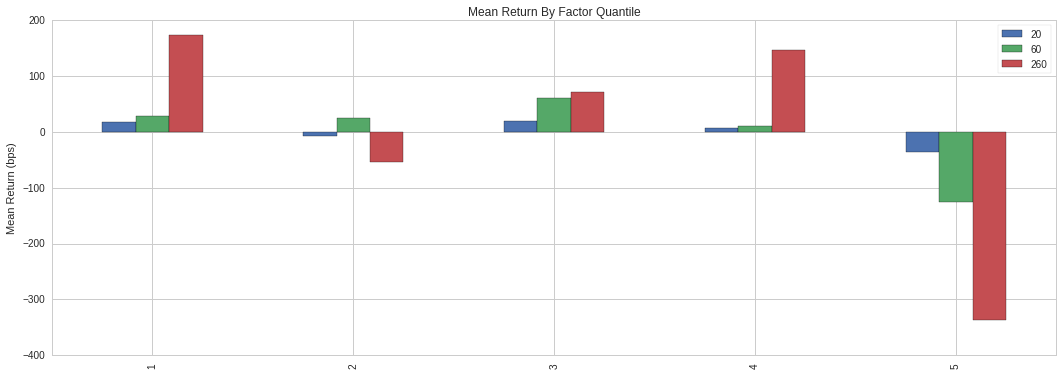

In [145]:
al.plotting.plot_quantile_returns_bar(mean_return_by_q);

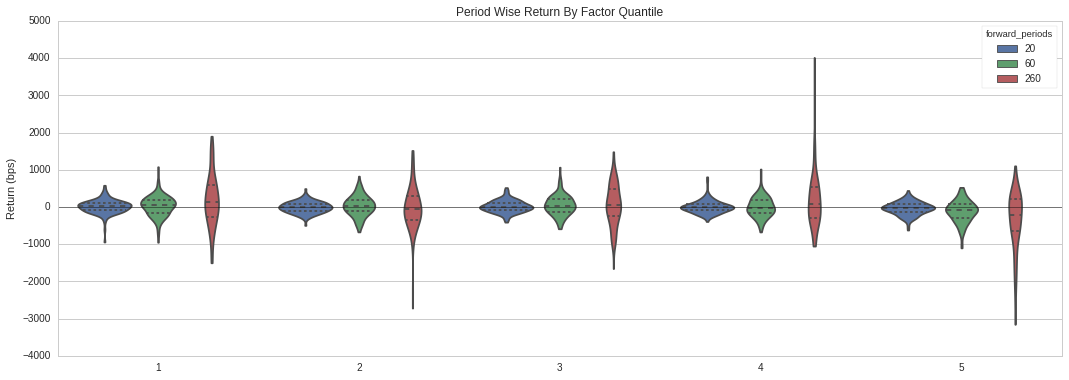

In [146]:
al.plotting.plot_quantile_returns_violin(mean_return_by_q_daily);

/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:519: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).mean()
  pd.rolling_mean(mean_returns_spread_bps, 22).plot(color='orangered',


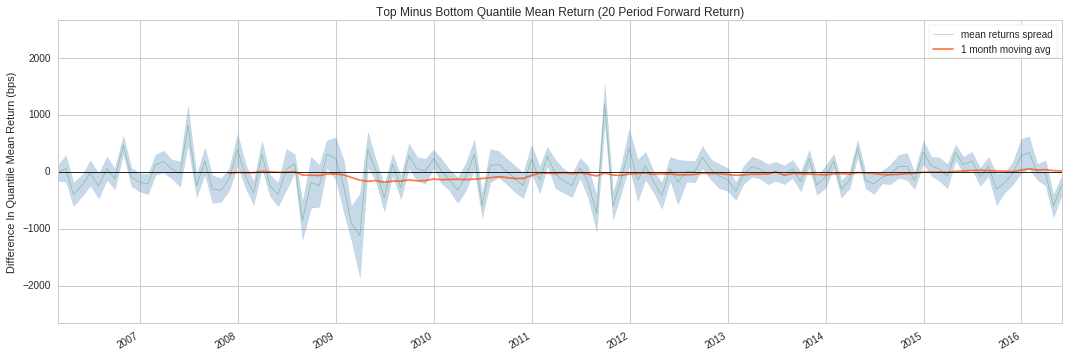

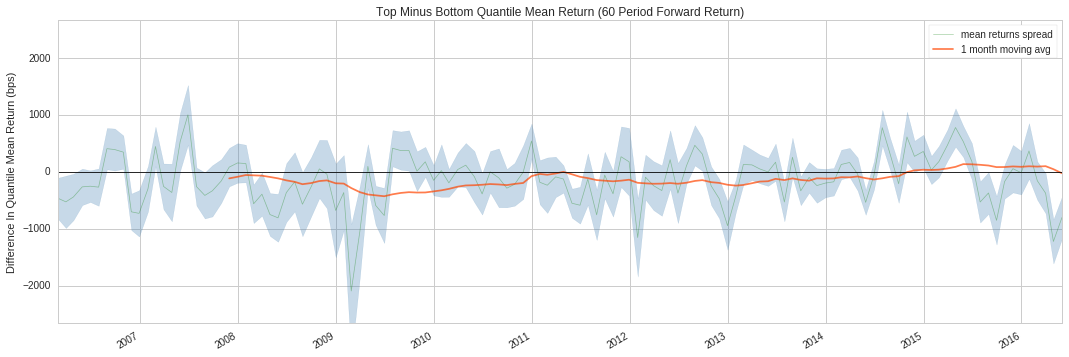

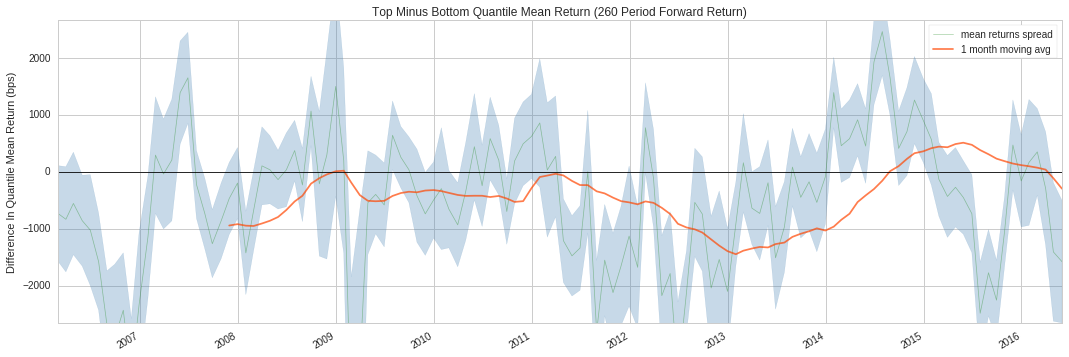

In [147]:
quant_return_spread, std_err_spread = \
al.performance.compute_mean_returns_spread(mean_return_by_q_daily,
                                           upper_quant=5,
                                           lower_quant=1,
                                           std_err=std_err_by_q_daily)

al.plotting.plot_mean_quantile_returns_spread_time_series(quant_return_spread, std_err_spread);

KeyError: 'date'

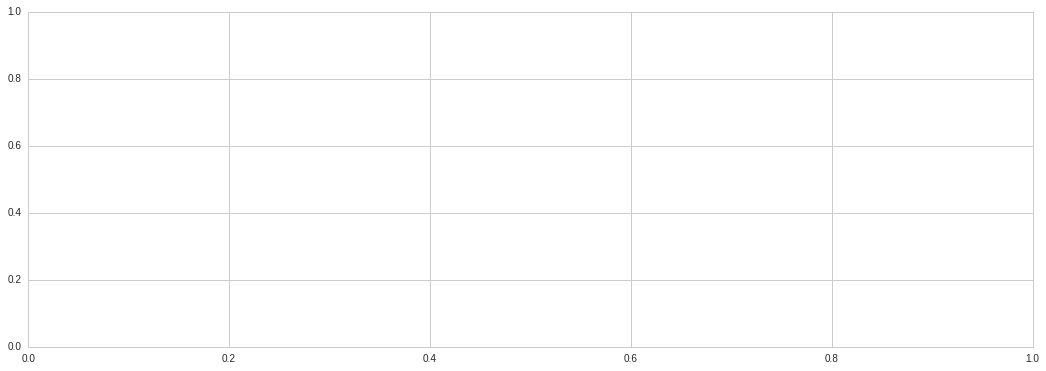

In [152]:
al.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q);

al.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q_daily);

ls_factor_returns = al.performance.factor_returns(factor_data);
ls_factor_returns.head()

al.plotting.plot_cumulative_returns(ls_factor_returns[1]);
alpha_beta = al.performance.factor_alpha_beta(factor_data)
# alpha_beta
al.tears.create_returns_tear_sheet(factor_data)
mean_return_quantile_sector, mean_return_quantile_sector_err = \
al.performance.mean_return_by_quantile(factor_data, by_group=True)
mean_return_quantile_sector.head()

al.plotting.plot_quantile_returns_bar(mean_return_quantile_sector, by_group=True);

## acctg_lists <a id='acctg_lists'></a>



[Universe Screen](#Universe) | [Functions](#Convenience Functions) | [Custom Factors](#Custom Factors)<br>
[Pipeline](#Pipeline) | [processing pipeline](#acctg_pipes_loaded) | [nfo](#nfo wrangling) | [Fundamentals](#FS wrangling) | [buffer](#buffer)<br>
[acctg_lists](#acctg_lists) | [acctg_pipes](#acctg_pipes) | [Code Snipets](#Code Snipets)


## CFS pipes <a id='acctg_pipes'></a>



[Universe Filters](#Universe) | [Functions](#Convenience Functions) | [Custom Factors](#Custom Factors)<br>
[Pipeline](#Pipeline) | [processing pipeline](#acctg_pipes_loaded) | [nfo](#nfo wrangling) | [Fundamentals](#FS wrangling)<br>
[buffer](#buffer) | [FS Reformulation](#FS Reformulation) | [Rolling Apply](#Rolling Apply) <br> 
[acctg_lists](#acctg_lists) | [acctg_pipes](#acctg_pipes) | [Code Snipets](#Code Snipets)


[<font color = 'red'>After loading the following pipes are loaded click here to run pipeline </font>](#acctg_pipes_loaded)<br>

## Full acctg pipe <a id='Full acctg pipe'></a>



[Universe Filters](#Universe) | [Functions](#Convenience Functions) | [Custom Factors](#Custom Factors)<br>
[Pipeline](#Pipeline) | [processing pipeline](#acctg_pipes_loaded) | [nfo](#nfo wrangling) | [Fundamentals](#FS wrangling)<br>
[buffer](#buffer) | [FS Reformulation](#FS Reformulation) | [Rolling Apply](#Rolling Apply) <br> 
[acctg_lists](#acctg_lists) | [acctg_pipes](#acctg_pipes) | [Code Snipets](#Code Snipets)


## Code Snipets <a id='Code Snipets'></a>


In [ ]:
# null or nonnull values---------------------------------------
x = data.ix[:,'financial_liabilities_current'].notnull()
x = data.ix[:,'period_ending_date'].isnull()
x = data.ix[:,'line_of_credit'].notnull()
data[x]
data[x].ix[:,['financial_liabilities_current',
              'financial_liabilities_non_current', 
              'sector_code']]
cash_test[cash_list].dropna(thresh=1).head()
df[1].fillna(0, inplace=True)
IS_f_1qtrAgo.dropna(axis=1, how='all').count().sort_values(ascending=False)

# (re)setting multiIndex pandas---------------------------------------
tnfo = nfo_df.reset_index()

tnfo[(tnfo.level_1 == symbols('GE')) &
     (tnfo.IS_asof_maxdates == '2016-12-31')].head()

tnfo = tnfo.set_index(['level_0','level_1'])
tnfo.index.names = [None,None]
nfo_df.index.names = ['level_0','level_1']

# equivalent slicing
nfo_df.xs(symbols('AVGO'), level = 1, axis = 0).loc['2017-05-10']
nfo_df.xs('2017-05-10').loc[symbols('AVGO')]

# auditing --------------------------------------

# multi index querying

BS_f_df.info()

nfo_df.loc[(slice(None),(symbols('AAPL'))),slice(None)] # 1 stock....no slice()

nfo_df.loc[(slice('2015-03-31', '2017-06-05'), slice(symbols('AAPL'))), 'max_asof'] # date range
nfo_df.loc[(('2015-03-31', '2017-06-05'), slice(symbols('AAPL'))), 'max_asof'] #2 date items

CFS_f_df.xs(symbols('CELG'), level = 1, axis = 0).loc['2016-10-20':'2017-6-03'] \
.filter(regex='CFS_amortization', axis =1).tail(30).iloc[::-1]

BS_f_df.xs(symbols('AAPL'), level = 1, axis = 0).loc['2016-10-20':'2017-6-04'] \
.filter(regex='investment', axis =1).iloc[::-1].dropna(axis = 1)

tx = IS_f_1qtrAgo.index.difference(IS_f_df.xs(current_end).index)
nfo_df.xs(tx[1], level = 1, axis = 0).iloc[::-1] # .iloc[::-1] -> reverses index order

t.IS_accrued_preferred_stock_dividends.quantile(np.arange(.1,1,.05))

nfo_df[nfo_df.BS_negNOA > 0].loc[(slice(None), (symbols('HPQ'))), :] # conditional on column value
IS_0yAgo_TTM.xs(symbols('AAPL')).loc[IS_0yAgo_TTM.xs(symbols('AAPL'))>0] # columns with values > 0
CFS_1yAgo_TTM.loc[(symbols('AAPL')),CFS_0yAgo_TTM.loc[(symbols('AAPL'))] != 0].head()
nfo_df.loc[('2017-06-05', symbols('AAPL'))]

# reshape---------------------------------------
data.index=data.index.droplevel(0)
data["symbol"] = [equity.symbol for equity in data.index.values]

# comparisons / filtering---------------------------------------
data[data['BS_as_of'] != data['period_ending_date']]
data[(data.FAotherSTinvt > 0) & (data.sector_code == 308)]
data[data.FAotherSTinvt > 0].groupby("sector_code").count()
data.ix[:,'bank_loans_current':].isnull().all(1).count()
IS_asof_df.loc[:, IS_asof_df.dtypes == '<M8[ns]'] # filter column by datatype

# info------------------------------------------------------------------
data[data.FAotherSTinvt > 0].count()
data.cash.isnull().sum()
IS_f_df.count().sort_values(ascending=False)
BS_itm_lst = list(BS_f_df) # list of col names

# add symbol column to all data frames---------------------------------------
BS_f_df.loc[:,'symbol'] = BS_asof_df.loc[:,'symbol'] = \
IS_f_df.loc[:,'symbol'] = IS_asof_df.loc[:,'symbol'] = \
CFS_f_df.loc[:,'symbol'] = CFS_asof_df.loc[:,'symbol'] = \
[equity.symbol for equity in BS_f_df.xs(end_date).index.values]

# datetime------------------------------------------------------------------------------
today = datetime.datetime.now().strftime('%Y-%m-%d')
date = datetime.datetime(year=2016, month=4, day=1)
end_date = datetime.strptime('2017-05-01', '%Y-%m-%d')

# slicing by symbol---------------------------------------
s = symbols('BAX')

BS_asof_maxdates.unstack()[s][end_date]
IS_asof_maxdates.unstack()[s][end_date]
CFS_asof_maxdates.unstack()[s][end_date]

# screens
min_mktcap_percentile = 10
market_cap = MarketCap().percentile_between(min_mktcap_percentile, 100)


# """get_pricing example"""----------------------------------
start = current_end - pd.Timedelta('3 days')
test = get_pricing(nfo_df.xs(current_end).index, start_date = start, end_date = current_end,  fields=['close_price'])
test

# Get returns data for our portfolio
portfolio = get_pricing(['MSFT', 'AAPL', 'YHOO', 'FB', 'TSLA'], 
                        fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
R = np.mean(portfolio, axis=1)

test['close_price']

In [66]:
range(-1, -5, -1)
# [-(i+1) for i in xrange(4)] 

[-1, -2, -3, -4]

In [73]:
# [-(i+5) for i in xrange(4)]

# [-(i+9) for i in xrange(4)]

[-9, -10, -11, -12]

In [ ]:
y0_Qidx =  xrange(-1, -5, -1)
y1_Qidx =  xrange(-5, -9, -1)
y2_Qidx =  xrange(-9, -13, -1)





In [52]:
[-(i+1) for i in xrange(4)] 

[-1, -2, -3, -4]

In [54]:
from itertools import islice
??islice()

In [2]:
for i in islice(4,1): print i

NameError: name 'islice' is not defined

In [5]:
from itertools import count
count(0, 10)

count(0, 10)